In [1]:
import argparse
import gym
from gym import wrappers
import os.path as osp
import random
import numpy as np
import itertools
import tensorflow as tf
import tensorflow.contrib.layers as layers

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
#from utils import plotting

import dqn_with_options as dqn
from dqn_utils_options import *
#from atari_wrappers import *
#from environments.arm_env.arm_env import ArmEnv
from arm_env_dqn_with_options import ArmEnvDQN
from option_class import option
import plotting

In [2]:
tf.__version__

'1.1.0'

In [3]:
def arm_model(img_in, num_actions, scope, reuse=False):
    # as described in https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
    with tf.variable_scope(scope, reuse=reuse):
        out = img_in
        with tf.variable_scope("convnet"):
            # original architecture
            out = layers.convolution2d(out, num_outputs=32, kernel_size=8, stride=4, activation_fn=tf.nn.relu)
            out = layers.convolution2d(out, num_outputs=64, kernel_size=4, stride=2, activation_fn=tf.nn.relu)
            out = layers.convolution2d(out, num_outputs=64, kernel_size=3, stride=1, activation_fn=tf.nn.relu)
        out = layers.flatten(out)
        with tf.variable_scope("action_value"):
            out = layers.fully_connected(out, num_outputs=256,         activation_fn=tf.nn.relu)
            out = layers.fully_connected(out, num_outputs=num_actions, activation_fn=None)

        return out


def arm_learn(env, options, session, num_timesteps):
    # This is just a rough estimate
    num_iterations = float(num_timesteps) / 4.0

    lr_multiplier = 1.0
    lr_schedule = PiecewiseSchedule([
                                         (0,                   1e-4 * lr_multiplier),
                                         (num_iterations / 10, 1e-4 * lr_multiplier),
                                         (num_iterations / 2,  5e-5 * lr_multiplier),
                                    ],
                                    outside_value=5e-5 * lr_multiplier)
    optimizer = dqn.OptimizerSpec(
        constructor=tf.train.AdamOptimizer,
        kwargs=dict(epsilon=1e-4),
        lr_schedule=lr_schedule
    )

    def stopping_criterion(env, t):
        # notice that here t is the number of steps of the wrapped env,
        # which is different from the number of steps in the underlying env
        return t >= num_timesteps

    exploration_schedule = PiecewiseSchedule(
        [
            (0, 1.0),
            (80000, 0.3),
            (200000, 0.01),
        ], outside_value=0.01
    )

    dqn.learn(
        env,
        options = options,
        q_func=arm_model,
        optimizer_spec=optimizer,
        session=session,
        exploration=exploration_schedule,
        stopping_criterion=stopping_criterion,
        replay_buffer_size=1000000,
        batch_size=32,
        gamma=0.99,
        learning_starts=5000,
        learning_freq=1,
        frame_history_len=1,
        target_update_freq=200,
        grad_norm_clipping=10
    )
    
    ep_rew = env.get_episode_rewards()
    ep_len = env.get_episode_lengths()
    env.close()
    return ep_rew, ep_len

def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']

def set_global_seeds(i):
    try:
        import tensorflow as tf
    except ImportError:
        pass
    else:
        tf.set_random_seed(i) 
    np.random.seed(i)
    random.seed(i)

def get_session():
    tf.reset_default_graph()
#     tf_config = tf.ConfigProto(
#         inter_op_parallelism_threads=1,
#         intra_op_parallelism_threads=1)
    session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    print("AVAILABLE GPUS: ", get_available_gpus())
    session = tf.Session()
    return session



AVAILABLE GPUS:  []
INFO:tensorflow:Restoring parameters from option1_6_4_4/dqn_graph.ckpt


[2018-05-14 21:17:33,348] Restoring parameters from option1_6_4_4/dqn_graph.ckpt


INFO:tensorflow:Restoring parameters from option2/dqn_graph.ckpt


[2018-05-14 21:17:33,683] Restoring parameters from option2/dqn_graph.ckpt


Timestep 5500
mean reward (50 episodes) -428.481481
mean length (50 episodes) 197.000000
max_episode_reward (50 episodes) -213.000000
min_episode_length (50 episodes) 119.000000
min_episode_reward (50 episodes) -586.000000
max_episode_length (50 episodes) 200.000000
best mean reward -319.000000
episodes 27
exploration 0.951875
learning_rate 0.000100


Timestep 6000
mean reward (50 episodes) -424.200000
mean length (50 episodes) 197.300000
max_episode_reward (50 episodes) -213.000000
min_episode_length (50 episodes) 119.000000
min_episode_reward (50 episodes) -586.000000
max_episode_length (50 episodes) 200.000000
best mean reward -319.000000
episodes 30
exploration 0.947500
learning_rate 0.000100


Timestep 6500
mean reward (50 episodes) -420.062500
mean length (50 episodes) 197.468750
max_episode_reward (50 episodes) -213.000000
min_episode_length (50 episodes) 119.000000
min_episode_reward (50 episodes) -586.000000
max_episode_length (50 episodes) 200.000000
best mean reward -319.000

Timestep 17500
mean reward (50 episodes) -371.480000
mean length (50 episodes) 193.760000
max_episode_reward (50 episodes) -99.000000
min_episode_length (50 episodes) 89.000000
min_episode_reward (50 episodes) -581.000000
max_episode_length (50 episodes) 200.000000
best mean reward -319.000000
episodes 89
exploration 0.846875
learning_rate 0.000095


Timestep 18000
mean reward (50 episodes) -370.240000
mean length (50 episodes) 194.840000
max_episode_reward (50 episodes) -99.000000
min_episode_length (50 episodes) 89.000000
min_episode_reward (50 episodes) -574.000000
max_episode_length (50 episodes) 200.000000
best mean reward -319.000000
episodes 91
exploration 0.842500
learning_rate 0.000095


Timestep 18500
mean reward (50 episodes) -369.400000
mean length (50 episodes) 193.540000
max_episode_reward (50 episodes) -81.000000
min_episode_length (50 episodes) 89.000000
min_episode_reward (50 episodes) -574.000000
max_episode_length (50 episodes) 200.000000
best mean reward -319.000000

Timestep 29500
mean reward (50 episodes) -340.940000
mean length (50 episodes) 193.840000
max_episode_reward (50 episodes) -26.000000
min_episode_length (50 episodes) 84.000000
min_episode_reward (50 episodes) -565.000000
max_episode_length (50 episodes) 200.000000
best mean reward -319.000000
episodes 150
exploration 0.741875
learning_rate 0.000083


Timestep 30000
mean reward (50 episodes) -333.180000
mean length (50 episodes) 193.840000
max_episode_reward (50 episodes) -26.000000
min_episode_length (50 episodes) 84.000000
min_episode_reward (50 episodes) -565.000000
max_episode_length (50 episodes) 200.000000
best mean reward -319.000000
episodes 153
exploration 0.737500
learning_rate 0.000082


Timestep 30500
mean reward (50 episodes) -329.440000
mean length (50 episodes) 193.840000
max_episode_reward (50 episodes) -26.000000
min_episode_length (50 episodes) 84.000000
min_episode_reward (50 episodes) -565.000000
max_episode_length (50 episodes) 200.000000
best mean reward -319.0000

Timestep 41500
mean reward (50 episodes) -259.820000
mean length (50 episodes) 177.360000
max_episode_reward (50 episodes) 28.000000
min_episode_length (50 episodes) 41.000000
min_episode_reward (50 episodes) -431.000000
max_episode_length (50 episodes) 200.000000
best mean reward -258.880000
episodes 218
exploration 0.636875
learning_rate 0.000071


Timestep 42000
mean reward (50 episodes) -254.220000
mean length (50 episodes) 175.240000
max_episode_reward (50 episodes) 28.000000
min_episode_length (50 episodes) 41.000000
min_episode_reward (50 episodes) -431.000000
max_episode_length (50 episodes) 200.000000
best mean reward -254.020000
episodes 221
exploration 0.632500
learning_rate 0.000071


Timestep 42500
mean reward (50 episodes) -245.740000
mean length (50 episodes) 170.380000
max_episode_reward (50 episodes) 28.000000
min_episode_length (50 episodes) 41.000000
min_episode_reward (50 episodes) -431.000000
max_episode_length (50 episodes) 200.000000
best mean reward -243.740000


Timestep 53500
mean reward (50 episodes) -189.260000
mean length (50 episodes) 153.860000
max_episode_reward (50 episodes) 46.000000
min_episode_length (50 episodes) 30.000000
min_episode_reward (50 episodes) -390.000000
max_episode_length (50 episodes) 200.000000
best mean reward -181.260000
episodes 293
exploration 0.531875
learning_rate 0.000059


Timestep 54000
mean reward (50 episodes) -179.720000
mean length (50 episodes) 147.500000
max_episode_reward (50 episodes) 46.000000
min_episode_length (50 episodes) 30.000000
min_episode_reward (50 episodes) -390.000000
max_episode_length (50 episodes) 200.000000
best mean reward -179.720000
episodes 297
exploration 0.527500
learning_rate 0.000059


Timestep 54500
mean reward (50 episodes) -171.880000
mean length (50 episodes) 143.000000
max_episode_reward (50 episodes) 46.000000
min_episode_length (50 episodes) 30.000000
min_episode_reward (50 episodes) -390.000000
max_episode_length (50 episodes) 200.000000
best mean reward -167.600000


Timestep 65500
mean reward (50 episodes) -136.220000
mean length (50 episodes) 129.160000
max_episode_reward (50 episodes) 51.000000
min_episode_length (50 episodes) 23.000000
min_episode_reward (50 episodes) -356.000000
max_episode_length (50 episodes) 200.000000
best mean reward -132.820000
episodes 384
exploration 0.426875
learning_rate 0.000050


Timestep 66000
mean reward (50 episodes) -142.800000
mean length (50 episodes) 132.640000
max_episode_reward (50 episodes) 51.000000
min_episode_length (50 episodes) 23.000000
min_episode_reward (50 episodes) -356.000000
max_episode_length (50 episodes) 200.000000
best mean reward -132.820000
episodes 387
exploration 0.422500
learning_rate 0.000050


Timestep 66500
mean reward (50 episodes) -129.440000
mean length (50 episodes) 125.380000
max_episode_reward (50 episodes) 50.000000
min_episode_length (50 episodes) 26.000000
min_episode_reward (50 episodes) -356.000000
max_episode_length (50 episodes) 200.000000
best mean reward -129.440000


Timestep 77500
mean reward (50 episodes) 40.080000
mean length (50 episodes) 23.600000
max_episode_reward (50 episodes) 62.000000
min_episode_length (50 episodes) 12.000000
min_episode_reward (50 episodes) -42.000000
max_episode_length (50 episodes) 68.000000
best mean reward 40.080000
episodes 633
exploration 0.321875
learning_rate 0.000050


Timestep 78000
mean reward (50 episodes) 42.280000
mean length (50 episodes) 23.620000
max_episode_reward (50 episodes) 62.000000
min_episode_length (50 episodes) 11.000000
min_episode_reward (50 episodes) -22.000000
max_episode_length (50 episodes) 70.000000
best mean reward 42.580000
episodes 653
exploration 0.317500
learning_rate 0.000050


Timestep 78500
mean reward (50 episodes) 37.280000
mean length (50 episodes) 26.360000
max_episode_reward (50 episodes) 62.000000
min_episode_length (50 episodes) 11.000000
min_episode_reward (50 episodes) -51.000000
max_episode_length (50 episodes) 76.000000
best mean reward 42.580000
episodes 665
explorat

Timestep 89500
mean reward (50 episodes) 28.560000
mean length (50 episodes) 35.960000
max_episode_reward (50 episodes) 63.000000
min_episode_length (50 episodes) 13.000000
min_episode_reward (50 episodes) -140.000000
max_episode_length (50 episodes) 164.000000
best mean reward 52.800000
episodes 1098
exploration 0.277042
learning_rate 0.000050


Timestep 90000
mean reward (50 episodes) 24.740000
mean length (50 episodes) 40.400000
max_episode_reward (50 episodes) 61.000000
min_episode_length (50 episodes) 13.000000
min_episode_reward (50 episodes) -140.000000
max_episode_length (50 episodes) 164.000000
best mean reward 52.800000
episodes 1110
exploration 0.275833
learning_rate 0.000050


Timestep 90500
mean reward (50 episodes) 23.760000
mean length (50 episodes) 43.180000
max_episode_reward (50 episodes) 63.000000
min_episode_length (50 episodes) 12.000000
min_episode_reward (50 episodes) -140.000000
max_episode_length (50 episodes) 164.000000
best mean reward 52.800000
episodes 1126

Timestep 101500
mean reward (50 episodes) 42.420000
mean length (50 episodes) 29.620000
max_episode_reward (50 episodes) 62.000000
min_episode_length (50 episodes) 14.000000
min_episode_reward (50 episodes) -5.000000
max_episode_length (50 episodes) 78.000000
best mean reward 52.800000
episodes 1556
exploration 0.248042
learning_rate 0.000050


Timestep 102000
mean reward (50 episodes) 45.960000
mean length (50 episodes) 24.060000
max_episode_reward (50 episodes) 63.000000
min_episode_length (50 episodes) 13.000000
min_episode_reward (50 episodes) -6.000000
max_episode_length (50 episodes) 60.000000
best mean reward 52.800000
episodes 1579
exploration 0.246833
learning_rate 0.000050


Timestep 102500
mean reward (50 episodes) 49.240000
mean length (50 episodes) 19.520000
max_episode_reward (50 episodes) 63.000000
min_episode_length (50 episodes) 13.000000
min_episode_reward (50 episodes) -6.000000
max_episode_length (50 episodes) 51.000000
best mean reward 52.800000
episodes 1605
explo

Timestep 113500
mean reward (50 episodes) 55.440000
mean length (50 episodes) 19.840000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 14.000000
min_episode_reward (50 episodes) 8.000000
max_episode_length (50 episodes) 33.000000
best mean reward 57.020000
episodes 2131
exploration 0.219042
learning_rate 0.000050


Timestep 114000
mean reward (50 episodes) 56.400000
mean length (50 episodes) 20.860000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 14.000000
min_episode_reward (50 episodes) 31.000000
max_episode_length (50 episodes) 34.000000
best mean reward 57.020000
episodes 2152
exploration 0.217833
learning_rate 0.000050


Timestep 114500
mean reward (50 episodes) 54.820000
mean length (50 episodes) 21.180000
max_episode_reward (50 episodes) 67.000000
min_episode_length (50 episodes) 14.000000
min_episode_reward (50 episodes) 31.000000
max_episode_length (50 episodes) 34.000000
best mean reward 57.020000
episodes 2176
explor

Timestep 125500
mean reward (50 episodes) 59.080000
mean length (50 episodes) 21.860000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 11.000000
max_episode_length (50 episodes) 64.000000
best mean reward 63.020000
episodes 2671
exploration 0.190042
learning_rate 0.000050


Timestep 126000
mean reward (50 episodes) 59.460000
mean length (50 episodes) 21.740000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 11.000000
max_episode_length (50 episodes) 64.000000
best mean reward 63.020000
episodes 2695
exploration 0.188833
learning_rate 0.000050


Timestep 126500
mean reward (50 episodes) 61.160000
mean length (50 episodes) 20.560000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 14.000000
min_episode_reward (50 episodes) 27.000000
max_episode_length (50 episodes) 49.000000
best mean reward 63.020000
episodes 2717
explo

Timestep 137500
mean reward (50 episodes) 64.580000
mean length (50 episodes) 18.520000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 50.000000
max_episode_length (50 episodes) 27.000000
best mean reward 64.580000
episodes 3250
exploration 0.161042
learning_rate 0.000050


Timestep 138000
mean reward (50 episodes) 64.300000
mean length (50 episodes) 18.640000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 47.000000
max_episode_length (50 episodes) 27.000000
best mean reward 64.800000
episodes 3275
exploration 0.159833
learning_rate 0.000050


Timestep 138500
mean reward (50 episodes) 63.780000
mean length (50 episodes) 18.900000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 14.000000
min_episode_reward (50 episodes) 47.000000
max_episode_length (50 episodes) 27.000000
best mean reward 64.800000
episodes 3300
explo

Timestep 149500
mean reward (50 episodes) 63.920000
mean length (50 episodes) 19.680000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 37.000000
max_episode_length (50 episodes) 39.000000
best mean reward 65.360000
episodes 3846
exploration 0.132042
learning_rate 0.000050


Timestep 150000
mean reward (50 episodes) 63.360000
mean length (50 episodes) 19.840000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 34.000000
max_episode_length (50 episodes) 39.000000
best mean reward 65.360000
episodes 3870
exploration 0.130833
learning_rate 0.000050


Timestep 150500
mean reward (50 episodes) 63.600000
mean length (50 episodes) 19.600000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 34.000000
max_episode_length (50 episodes) 27.000000
best mean reward 65.360000
episodes 3895
explo

Timestep 161500
mean reward (50 episodes) 65.340000
mean length (50 episodes) 19.800000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 16.000000
min_episode_reward (50 episodes) 48.000000
max_episode_length (50 episodes) 31.000000
best mean reward 65.780000
episodes 4421
exploration 0.103042
learning_rate 0.000050


Timestep 162000
mean reward (50 episodes) 65.180000
mean length (50 episodes) 19.360000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 16.000000
min_episode_reward (50 episodes) 47.000000
max_episode_length (50 episodes) 31.000000
best mean reward 65.780000
episodes 4446
exploration 0.101833
learning_rate 0.000050


Timestep 162500
mean reward (50 episodes) 66.360000
mean length (50 episodes) 18.560000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 47.000000
max_episode_length (50 episodes) 23.000000
best mean reward 66.620000
episodes 4472
explo

Timestep 173500
mean reward (50 episodes) 66.460000
mean length (50 episodes) 20.160000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 16.000000
min_episode_reward (50 episodes) 55.000000
max_episode_length (50 episodes) 26.000000
best mean reward 66.900000
episodes 5007
exploration 0.074042
learning_rate 0.000050


Timestep 174000
mean reward (50 episodes) 66.200000
mean length (50 episodes) 20.480000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 16.000000
min_episode_reward (50 episodes) 55.000000
max_episode_length (50 episodes) 27.000000
best mean reward 66.900000
episodes 5030
exploration 0.072833
learning_rate 0.000050


Timestep 174500
mean reward (50 episodes) 66.120000
mean length (50 episodes) 20.560000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 16.000000
min_episode_reward (50 episodes) 57.000000
max_episode_length (50 episodes) 27.000000
best mean reward 66.900000
episodes 5053
explo

Timestep 185500
mean reward (50 episodes) 67.620000
mean length (50 episodes) 18.380000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 61.000000
max_episode_length (50 episodes) 23.000000
best mean reward 68.020000
episodes 5589
exploration 0.045042
learning_rate 0.000050


Timestep 186000
mean reward (50 episodes) 67.560000
mean length (50 episodes) 19.700000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 56.000000
max_episode_length (50 episodes) 24.000000
best mean reward 68.020000
episodes 5613
exploration 0.043833
learning_rate 0.000050


Timestep 186500
mean reward (50 episodes) 67.600000
mean length (50 episodes) 19.880000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 48.000000
max_episode_length (50 episodes) 24.000000
best mean reward 68.020000
episodes 5637
explo

Timestep 197500
mean reward (50 episodes) 68.540000
mean length (50 episodes) 19.120000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 16.000000
min_episode_reward (50 episodes) 61.000000
max_episode_length (50 episodes) 24.000000
best mean reward 68.740000
episodes 6195
exploration 0.016042
learning_rate 0.000050


Timestep 198000
mean reward (50 episodes) 68.260000
mean length (50 episodes) 19.320000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 46.000000
max_episode_length (50 episodes) 23.000000
best mean reward 68.740000
episodes 6219
exploration 0.014833
learning_rate 0.000050


Timestep 198500
mean reward (50 episodes) 68.100000
mean length (50 episodes) 19.160000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 46.000000
max_episode_length (50 episodes) 22.000000
best mean reward 68.740000
episodes 6244
explo

Timestep 209500
mean reward (50 episodes) 68.760000
mean length (50 episodes) 18.460000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 67.000000
max_episode_length (50 episodes) 21.000000
best mean reward 69.060000
episodes 6802
exploration 0.010000
learning_rate 0.000050


Timestep 210000
mean reward (50 episodes) 68.840000
mean length (50 episodes) 17.980000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 67.000000
max_episode_length (50 episodes) 21.000000
best mean reward 69.060000
episodes 6828
exploration 0.010000
learning_rate 0.000050


Timestep 210500
mean reward (50 episodes) 67.340000
mean length (50 episodes) 20.060000
max_episode_reward (50 episodes) 69.000000
min_episode_length (50 episodes) 14.000000
min_episode_reward (50 episodes) 16.000000
max_episode_length (50 episodes) 77.000000
best mean reward 69.060000
episodes 6849
explo

Timestep 221500
mean reward (50 episodes) 68.660000
mean length (50 episodes) 19.500000
max_episode_reward (50 episodes) 72.000000
min_episode_length (50 episodes) 15.000000
min_episode_reward (50 episodes) 63.000000
max_episode_length (50 episodes) 26.000000
best mean reward 69.060000
episodes 7399
exploration 0.010000
learning_rate 0.000050


Timestep 222000
mean reward (50 episodes) 68.820000
mean length (50 episodes) 19.280000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 16.000000
min_episode_reward (50 episodes) 63.000000
max_episode_length (50 episodes) 22.000000
best mean reward 69.060000
episodes 7424
exploration 0.010000
learning_rate 0.000050


Timestep 222500
mean reward (50 episodes) 68.440000
mean length (50 episodes) 18.900000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 16.000000
min_episode_reward (50 episodes) 48.000000
max_episode_length (50 episodes) 23.000000
best mean reward 69.060000
episodes 7450
explo

Timestep 233500
mean reward (50 episodes) 72.640000
mean length (50 episodes) 18.920000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 69.000000
max_episode_length (50 episodes) 23.000000
best mean reward 72.800000
episodes 7994
exploration 0.010000
learning_rate 0.000050


Timestep 234000
mean reward (50 episodes) 72.660000
mean length (50 episodes) 19.140000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 69.000000
max_episode_length (50 episodes) 23.000000
best mean reward 72.800000
episodes 8019
exploration 0.010000
learning_rate 0.000050


Timestep 234500
mean reward (50 episodes) 72.460000
mean length (50 episodes) 18.120000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 64.000000
max_episode_length (50 episodes) 25.000000
best mean reward 72.800000
episodes 8046
explo

Timestep 245500
mean reward (50 episodes) 72.600000
mean length (50 episodes) 19.540000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 67.000000
max_episode_length (50 episodes) 23.000000
best mean reward 72.900000
episodes 8581
exploration 0.010000
learning_rate 0.000050


Timestep 246000
mean reward (50 episodes) 72.520000
mean length (50 episodes) 19.720000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 65.000000
max_episode_length (50 episodes) 25.000000
best mean reward 72.900000
episodes 8606
exploration 0.010000
learning_rate 0.000050


Timestep 246500
mean reward (50 episodes) 72.800000
mean length (50 episodes) 19.400000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 65.000000
max_episode_length (50 episodes) 25.000000
best mean reward 72.900000
episodes 8630
explo

Timestep 257500
mean reward (50 episodes) 72.740000
mean length (50 episodes) 19.940000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 69.000000
max_episode_length (50 episodes) 23.000000
best mean reward 72.940000
episodes 9158
exploration 0.010000
learning_rate 0.000050


Timestep 258000
mean reward (50 episodes) 72.780000
mean length (50 episodes) 19.500000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 69.000000
max_episode_length (50 episodes) 23.000000
best mean reward 72.940000
episodes 9183
exploration 0.010000
learning_rate 0.000050


Timestep 258500
mean reward (50 episodes) 72.760000
mean length (50 episodes) 20.080000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 71.000000
max_episode_length (50 episodes) 23.000000
best mean reward 72.940000
episodes 9206
explo

Timestep 269500
mean reward (50 episodes) 72.780000
mean length (50 episodes) 19.860000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 18.000000
min_episode_reward (50 episodes) 70.000000
max_episode_length (50 episodes) 24.000000
best mean reward 72.960000
episodes 9735
exploration 0.010000
learning_rate 0.000050


Timestep 270000
mean reward (50 episodes) 72.600000
mean length (50 episodes) 19.740000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 65.000000
max_episode_length (50 episodes) 25.000000
best mean reward 72.960000
episodes 9759
exploration 0.010000
learning_rate 0.000050


Timestep 270500
mean reward (50 episodes) 72.480000
mean length (50 episodes) 19.340000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 65.000000
max_episode_length (50 episodes) 25.000000
best mean reward 72.960000
episodes 9784
explo

Timestep 281500
mean reward (50 episodes) 72.440000
mean length (50 episodes) 20.160000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 62.000000
max_episode_length (50 episodes) 25.000000
best mean reward 72.960000
episodes 10315
exploration 0.010000
learning_rate 0.000050


Timestep 282000
mean reward (50 episodes) 72.340000
mean length (50 episodes) 19.640000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 62.000000
max_episode_length (50 episodes) 25.000000
best mean reward 72.960000
episodes 10340
exploration 0.010000
learning_rate 0.000050


Timestep 282500
mean reward (50 episodes) 72.220000
mean length (50 episodes) 20.080000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 62.000000
max_episode_length (50 episodes) 25.000000
best mean reward 72.960000
episodes 10363
ex

Timestep 293500
mean reward (50 episodes) 72.460000
mean length (50 episodes) 19.100000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 65.000000
max_episode_length (50 episodes) 22.000000
best mean reward 73.000000
episodes 10885
exploration 0.010000
learning_rate 0.000050


Timestep 294000
mean reward (50 episodes) 72.540000
mean length (50 episodes) 20.040000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 65.000000
max_episode_length (50 episodes) 24.000000
best mean reward 73.000000
episodes 10908
exploration 0.010000
learning_rate 0.000050


Timestep 294500
mean reward (50 episodes) 72.640000
mean length (50 episodes) 20.360000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 18.000000
min_episode_reward (50 episodes) 65.000000
max_episode_length (50 episodes) 24.000000
best mean reward 73.000000
episodes 10932
ex

Timestep 305500
mean reward (50 episodes) 72.660000
mean length (50 episodes) 19.920000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 69.000000
max_episode_length (50 episodes) 23.000000
best mean reward 73.000000
episodes 11457
exploration 0.010000
learning_rate 0.000050


Timestep 306000
mean reward (50 episodes) 72.680000
mean length (50 episodes) 20.380000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 18.000000
min_episode_reward (50 episodes) 69.000000
max_episode_length (50 episodes) 23.000000
best mean reward 73.000000
episodes 11481
exploration 0.010000
learning_rate 0.000050


Timestep 306500
mean reward (50 episodes) 72.760000
mean length (50 episodes) 20.600000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 19.000000
min_episode_reward (50 episodes) 69.000000
max_episode_length (50 episodes) 23.000000
best mean reward 73.000000
episodes 11504
ex

Timestep 317500
mean reward (50 episodes) 72.700000
mean length (50 episodes) 21.300000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 19.000000
min_episode_reward (50 episodes) 69.000000
max_episode_length (50 episodes) 25.000000
best mean reward 73.000000
episodes 12022
exploration 0.010000
learning_rate 0.000050


Timestep 318000
mean reward (50 episodes) 72.700000
mean length (50 episodes) 20.620000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 67.000000
max_episode_length (50 episodes) 25.000000
best mean reward 73.000000
episodes 12047
exploration 0.010000
learning_rate 0.000050


Timestep 318500
mean reward (50 episodes) 72.380000
mean length (50 episodes) 20.060000
max_episode_reward (50 episodes) 73.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 67.000000
max_episode_length (50 episodes) 24.000000
best mean reward 73.000000
episodes 12070
ex

Timestep 329500
mean reward (50 episodes) 73.200000
mean length (50 episodes) 21.580000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 17.000000
min_episode_reward (50 episodes) 67.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.700000
episodes 12560
exploration 0.010000
learning_rate 0.000050


Timestep 330000
mean reward (50 episodes) 73.500000
mean length (50 episodes) 23.200000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 18.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.700000
episodes 12580
exploration 0.010000
learning_rate 0.000050


Timestep 330500
mean reward (50 episodes) 73.780000
mean length (50 episodes) 23.860000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 22.000000
min_episode_reward (50 episodes) 70.000000
max_episode_length (50 episodes) 25.000000
best mean reward 73.780000
episodes 12601
ex

Timestep 341500
mean reward (50 episodes) 73.540000
mean length (50 episodes) 24.200000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 21.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 28.000000
best mean reward 73.880000
episodes 13057
exploration 0.010000
learning_rate 0.000050


Timestep 342000
mean reward (50 episodes) 73.600000
mean length (50 episodes) 23.780000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 21.000000
min_episode_reward (50 episodes) 69.000000
max_episode_length (50 episodes) 28.000000
best mean reward 73.880000
episodes 13078
exploration 0.010000
learning_rate 0.000050


Timestep 342500
mean reward (50 episodes) 73.480000
mean length (50 episodes) 23.840000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 21.000000
min_episode_reward (50 episodes) 69.000000
max_episode_length (50 episodes) 28.000000
best mean reward 73.880000
episodes 13098
ex

Timestep 353500
mean reward (50 episodes) 73.640000
mean length (50 episodes) 23.620000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 22.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 28.000000
best mean reward 73.880000
episodes 13551
exploration 0.010000
learning_rate 0.000050


Timestep 354000
mean reward (50 episodes) 73.700000
mean length (50 episodes) 23.280000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 21.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 27.000000
best mean reward 73.880000
episodes 13573
exploration 0.010000
learning_rate 0.000050


Timestep 354500
mean reward (50 episodes) 73.260000
mean length (50 episodes) 22.280000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 19.000000
min_episode_reward (50 episodes) 50.000000
max_episode_length (50 episodes) 25.000000
best mean reward 73.880000
episodes 13595
ex

Timestep 365500
mean reward (50 episodes) 73.680000
mean length (50 episodes) 22.640000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 67.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.880000
episodes 14053
exploration 0.010000
learning_rate 0.000050


Timestep 366000
mean reward (50 episodes) 73.520000
mean length (50 episodes) 22.600000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 18.000000
min_episode_reward (50 episodes) 66.000000
max_episode_length (50 episodes) 28.000000
best mean reward 73.880000
episodes 14074
exploration 0.010000
learning_rate 0.000050


Timestep 366500
mean reward (50 episodes) 73.600000
mean length (50 episodes) 22.760000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 18.000000
min_episode_reward (50 episodes) 66.000000
max_episode_length (50 episodes) 28.000000
best mean reward 73.880000
episodes 14095
ex

Timestep 377500
mean reward (50 episodes) 73.740000
mean length (50 episodes) 22.680000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 65.000000
max_episode_length (50 episodes) 25.000000
best mean reward 73.940000
episodes 14551
exploration 0.010000
learning_rate 0.000050


Timestep 378000
mean reward (50 episodes) 73.920000
mean length (50 episodes) 22.220000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 72.000000
max_episode_length (50 episodes) 25.000000
best mean reward 73.940000
episodes 14573
exploration 0.010000
learning_rate 0.000050


Timestep 378500
mean reward (50 episodes) 73.900000
mean length (50 episodes) 22.220000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 72.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 14594
ex

Timestep 389500
mean reward (50 episodes) 73.740000
mean length (50 episodes) 22.540000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 70.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 15049
exploration 0.010000
learning_rate 0.000050


Timestep 390000
mean reward (50 episodes) 73.480000
mean length (50 episodes) 23.100000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 66.000000
max_episode_length (50 episodes) 29.000000
best mean reward 73.940000
episodes 15069
exploration 0.010000
learning_rate 0.000050


Timestep 390500
mean reward (50 episodes) 73.500000
mean length (50 episodes) 23.040000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 66.000000
max_episode_length (50 episodes) 29.000000
best mean reward 73.940000
episodes 15091
ex

Timestep 401500
mean reward (50 episodes) 73.700000
mean length (50 episodes) 22.980000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 70.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 15546
exploration 0.010000
learning_rate 0.000050


Timestep 402000
mean reward (50 episodes) 73.560000
mean length (50 episodes) 22.840000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 70.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 15567
exploration 0.010000
learning_rate 0.000050


Timestep 402500
mean reward (50 episodes) 73.640000
mean length (50 episodes) 23.360000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 70.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 15588
ex

Timestep 413500
mean reward (50 episodes) 73.460000
mean length (50 episodes) 23.160000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 21.000000
min_episode_reward (50 episodes) 66.000000
max_episode_length (50 episodes) 27.000000
best mean reward 73.940000
episodes 16040
exploration 0.010000
learning_rate 0.000050


Timestep 414000
mean reward (50 episodes) 73.380000
mean length (50 episodes) 22.960000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 21.000000
min_episode_reward (50 episodes) 66.000000
max_episode_length (50 episodes) 25.000000
best mean reward 73.940000
episodes 16061
exploration 0.010000
learning_rate 0.000050


Timestep 414500
mean reward (50 episodes) 73.400000
mean length (50 episodes) 23.640000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 16081
ex

Timestep 425500
mean reward (50 episodes) 73.440000
mean length (50 episodes) 23.520000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 29.000000
best mean reward 73.940000
episodes 16533
exploration 0.010000
learning_rate 0.000050


Timestep 426000
mean reward (50 episodes) 73.580000
mean length (50 episodes) 23.960000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 29.000000
best mean reward 73.940000
episodes 16553
exploration 0.010000
learning_rate 0.000050


Timestep 426500
mean reward (50 episodes) 73.720000
mean length (50 episodes) 23.920000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 22.000000
min_episode_reward (50 episodes) 72.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 16573
ex

Timestep 437500
mean reward (50 episodes) 73.680000
mean length (50 episodes) 23.940000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 22.000000
min_episode_reward (50 episodes) 70.000000
max_episode_length (50 episodes) 28.000000
best mean reward 73.940000
episodes 17025
exploration 0.010000
learning_rate 0.000050


Timestep 438000
mean reward (50 episodes) 73.760000
mean length (50 episodes) 23.620000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 22.000000
min_episode_reward (50 episodes) 72.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 17045
exploration 0.010000
learning_rate 0.000050


Timestep 438500
mean reward (50 episodes) 73.620000
mean length (50 episodes) 22.920000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 17067
ex

Timestep 449500
mean reward (50 episodes) 73.740000
mean length (50 episodes) 22.860000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 18.000000
min_episode_reward (50 episodes) 72.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 17523
exploration 0.010000
learning_rate 0.000050


Timestep 450000
mean reward (50 episodes) 73.620000
mean length (50 episodes) 23.660000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 19.000000
min_episode_reward (50 episodes) 70.000000
max_episode_length (50 episodes) 28.000000
best mean reward 73.940000
episodes 17543
exploration 0.010000
learning_rate 0.000050


Timestep 450500
mean reward (50 episodes) 73.480000
mean length (50 episodes) 23.180000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 28.000000
best mean reward 73.940000
episodes 17565
ex

Timestep 461500
mean reward (50 episodes) 73.500000
mean length (50 episodes) 21.740000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 19.000000
min_episode_reward (50 episodes) 67.000000
max_episode_length (50 episodes) 25.000000
best mean reward 73.940000
episodes 18024
exploration 0.010000
learning_rate 0.000050


Timestep 462000
mean reward (50 episodes) 73.720000
mean length (50 episodes) 22.260000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 19.000000
min_episode_reward (50 episodes) 70.000000
max_episode_length (50 episodes) 25.000000
best mean reward 73.940000
episodes 18044
exploration 0.010000
learning_rate 0.000050


Timestep 462500
mean reward (50 episodes) 73.760000
mean length (50 episodes) 23.340000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 21.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 18065
ex

Timestep 473500
mean reward (50 episodes) 73.300000
mean length (50 episodes) 23.360000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 21.000000
min_episode_reward (50 episodes) 54.000000
max_episode_length (50 episodes) 27.000000
best mean reward 73.940000
episodes 18516
exploration 0.010000
learning_rate 0.000050


Timestep 474000
mean reward (50 episodes) 73.560000
mean length (50 episodes) 23.000000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 21.000000
min_episode_reward (50 episodes) 67.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 18537
exploration 0.010000
learning_rate 0.000050


Timestep 474500
mean reward (50 episodes) 73.680000
mean length (50 episodes) 23.080000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 21.000000
min_episode_reward (50 episodes) 67.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 18557
ex

Timestep 485500
mean reward (50 episodes) 73.180000
mean length (50 episodes) 22.560000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 18.000000
min_episode_reward (50 episodes) 46.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 19013
exploration 0.010000
learning_rate 0.000050


Timestep 486000
mean reward (50 episodes) 73.180000
mean length (50 episodes) 23.100000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 19.000000
min_episode_reward (50 episodes) 46.000000
max_episode_length (50 episodes) 27.000000
best mean reward 73.940000
episodes 19033
exploration 0.010000
learning_rate 0.000050


Timestep 486500
mean reward (50 episodes) 73.600000
mean length (50 episodes) 23.080000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 20.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 27.000000
best mean reward 73.940000
episodes 19055
ex

Timestep 497500
mean reward (50 episodes) 73.660000
mean length (50 episodes) 23.420000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 21.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 19507
exploration 0.010000
learning_rate 0.000050


Timestep 498000
mean reward (50 episodes) 73.600000
mean length (50 episodes) 23.480000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 21.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 26.000000
best mean reward 73.940000
episodes 19527
exploration 0.010000
learning_rate 0.000050


Timestep 498500
mean reward (50 episodes) 73.280000
mean length (50 episodes) 23.900000
max_episode_reward (50 episodes) 74.000000
min_episode_length (50 episodes) 22.000000
min_episode_reward (50 episodes) 68.000000
max_episode_length (50 episodes) 28.000000
best mean reward 73.940000
episodes 19547
ex

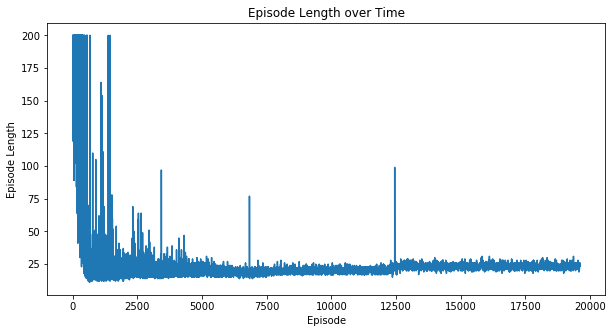

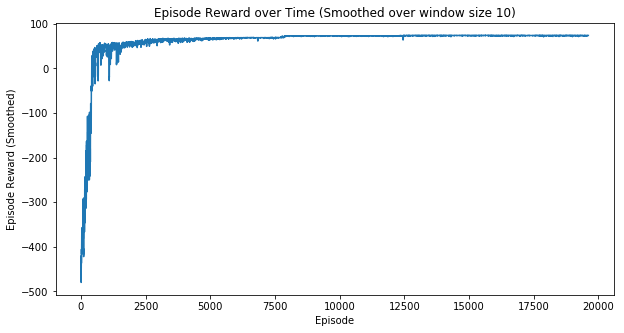

In [4]:
def main():
    # Get Atari games.
    # benchmark = gym.benchmark_spec('Atari40M')
    #
    # # Change the index to select a different game.
    # task = benchmark.tasks[3]
    #
    # # Run training
    seed = 0  # Use a seed of zero (you may want to randomize the seed!)
    set_global_seeds(seed)
    # env = get_env(task, seed)
    env = ArmEnvDQN(episode_max_length=200,
                 size_x=6,
                 size_y=4,
                 cubes_cnt=4,
                 scaling_coeff=3,
                 action_minus_reward=-1,
                 finish_reward=100,
                 tower_target_size=4)
    session = get_session()
    
    def stop_cond1(env):
        if env._arm_x+1 < env._size_x:
            if env._grid[env._arm_x+1, env._arm_y] == 1 and env._arm_x+2 >= env._size_x:
                return True
            if env._grid[env._arm_x+1, env._arm_y] == 1 and env._arm_x+2 < env._size_x:
                if env._grid[env._arm_x+2, env._arm_y] == 1:
                    return True
        else:
            return True
        return False
    def stop_cond2(env):
        if env._arm_x == 0 and env._grid[1, env._arm_y] == 1 and env._grid[2, env._arm_y] == 0:
            return True
        return False
            
    
    # initialize options
    options = [option(env, stop_cond1, path = "option1_6_4_4/dqn_graph.ckpt", import_scope = "option1_6_4_4"),
              option(env, stop_cond2, path = "option2/dqn_graph.ckpt", import_scope = "option2")]
    
    ep_rew, ep_len = arm_learn(env, options, session, num_timesteps=500000)
    
    thefile = open('ep_rew_6_4_4.txt', 'w')
    for item in ep_rew:
        thefile.write("%s\n" % item)
        
    thefile2 = open('ep_len_6_4_4.txt', 'w')
    for item in ep_len:
        thefile2.write("%s\n" % item)
        
    stats = plotting.EpisodeStats(
        episode_lengths=ep_len,
        episode_rewards=ep_rew)
    plotting.plot_episode_stats(stats)
#     tf.summary.FileWriter("logs", tf.get_default_graph()).close()

if __name__ == "__main__":
    main()

In [ ]:
! tensorboard --logdir=logs2

In [ ]:
def encode_observation(frame):
    img_h, img_w = frame.shape[1], frame.shape[2]
    return frame.transpose(1, 2, 0, 3).reshape(img_h, img_w, -1)

def main():
    env = ArmEnvDQN(episode_max_length=200,
                 size_x=5,
                 size_y=5,
                 cubes_cnt=4,
                 scaling_coeff=3,
                 action_minus_reward=-1,
                 finish_reward=400,
                 tower_target_size=4)
    # print(env.reset())
    session = tf.Session()
    # First let's load meta graph and restore weights
    saver = tf.train.import_meta_graph('my_test_model.meta')
    saver.restore(session, tf.train.latest_checkpoint('./'))
    frame_history_len = 1
    img_h, img_w, img_c = env.observation_space.shape
    input_shape = (img_h, img_w, frame_history_len * img_c)  # size_x, size_y,
    num_actions = env.action_space.n

#     # placeholder for current observation (or state)
#     obs_t_ph = tf.placeholder(tf.uint8, [None] + list(input_shape))
#     # casting to float on GPU ensures lower data transfer times.
#     obs_t_float = tf.cast(obs_t_ph, tf.float32) / 255.0



#     pred_q = q_func(obs_t_float, num_actions, scope="q_func", reuse=False)
#     pred_ac = tf.argmax(pred_q, axis=1)
    graph = tf.get_default_graph()

    obs_t_float = graph.get_tensor_by_name("obs_t_ph:0")
 
    ## How to access saved operation
    pred_ac = graph.get_tensor_by_name("pred_ac:0")
    
    
    episode_reward = 0
    episode_length = 0
    last_obs = env.reset()

    for t in itertools.count():

        obs = encode_observation(np.array([last_obs]))
        action = session.run(pred_ac, {obs_t_float: [obs]})[0]

        next_obs, reward, done, info = env.step(action)

        episode_reward += reward
        episode_length += 1

        if done or episode_length == 500:
            break

        last_obs = next_obs
    print(episode_reward, episode_length)


if __name__ == "__main__":
    main()